In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(r'spam.csv')

df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [5]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [6]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [8]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
print(df_balanced.shape)
df_balanced['Category'].value_counts()

(1494, 2)


ham     747
spam    747
Name: Category, dtype: int64

In [9]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
1749,ham,Feel Yourself That You Are Always Happy.. Slow...,0
4969,ham,Future is not what we planned for tomorrow.......,0
5043,spam,Jamster! To get your free wallpaper text HEART...,1
4546,ham,Never y lei... I v lazy... Got wat? Dat day ü ...,0
2548,spam,"Text82228>> Get more ringtones, logos and game...",1


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

# Build Model

In [11]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

2021-11-07 20:38:39.575400: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-07 20:38:39.581738: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-11-07 20:38:40.882548: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [12]:
# def get_sentence_embeding(sentences):
#     preprocessed_text = bert_preprocess(sentences)
#     return bert_encoder(preprocessed_text)['pooled_output']

In [13]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
hidden1 = tf.keras.layers.Dense(64, activation='sigmoid')(outputs['pooled_output'])
dropout1 = tf.keras.layers.Dropout(0.1, name="dropout")(hidden1)
hidden2 = tf.keras.layers.Dense(32, activation='sigmoid')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.1, name="dropout2")(hidden2)
hidden3 = tf.keras.layers.Dense(16, activation='sigmoid')(dropout2)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(hidden3)

# l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
# l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'sequence_output':  109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [14]:
model.compile(optimizer='adam',  loss='binary_crossentropy', metrics=['accuracy'])

# Training 

In [13]:
history = model.fit(X_train, y_train, epochs=5, batch_size=10,validation_split=0.33,)

Epoch 1/5
75/75 [==============================] - 73s 881ms/step - loss: 0.6764 - accuracy: 0.6320 - val_loss: 0.6398 - val_accuracy: 0.7676
Epoch 2/5
75/75 [==============================] - 62s 832ms/step - loss: 0.5682 - accuracy: 0.8240 - val_loss: 0.4665 - val_accuracy: 0.8784
Epoch 3/5
75/75 [==============================] - 63s 841ms/step - loss: 0.4063 - accuracy: 0.8853 - val_loss: 0.3548 - val_accuracy: 0.8649
Epoch 4/5
75/75 [==============================] - 61s 820ms/step - loss: 0.3274 - accuracy: 0.8960 - val_loss: 0.3020 - val_accuracy: 0.9081
Epoch 5/5
75/75 [==============================] - 62s 823ms/step - loss: 0.2934 - accuracy: 0.8987 - val_loss: 0.2645 - val_accuracy: 0.9027


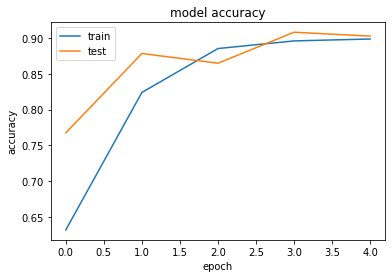

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

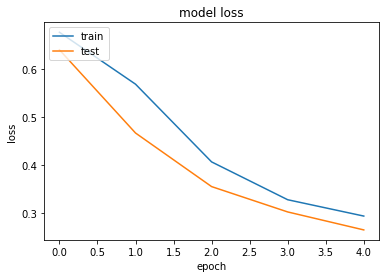

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evalulate

In [16]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 15s 1s/step - loss: 0.2671 - accuracy: 0.9037


[0.2671288549900055, 0.903743326663971]

# Test

In [17]:
reviews = [
    'Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.8618237 ],
       [0.8706215 ],
       [0.8635634 ],
       [0.10199586],
       [0.07559842]], dtype=float32)